# Import Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
from PIL import Image
import math
import time
import os
import numpy as np
import natsort
import csv

# Network Setting

In [2]:
epochSize = 100
batchSize = 120
testSize = 300
valSize = 120
learningRate = 4e-4
momentum = 0.5
printInterval = 6
outSize = 10

torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.set_device(0)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
GeForce GTX 1050


# Data Augumentation

In [3]:
import numbers
inputSize = 224
    
trainAugumentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(20,translate=(0.1,0.1),scale=(0.8,1)),    
    transforms.ToTensor(),
    transforms.Resize((inputSize,inputSize))
])

testAugumentation = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Resize((inputSize,inputSize))
])

# Data Sets

In [4]:
dataDir = "C://Users//jason//OneDrive//圖片//Machine Learning Data//CIFAR-10-images-master//"
trainDir = os.path.join(dataDir,'train//')
valDir = os.path.join(dataDir,'val//')
testDir = os.path.join(dataDir,'test//')

trainData = datasets.ImageFolder(trainDir,transform = trainAugumentation)
valData = datasets.ImageFolder(valDir,transform = trainAugumentation)
testData = datasets.ImageFolder(testDir,transform = testAugumentation)

# Data Loader

In [5]:
trainLoader = torch.utils.data.DataLoader(trainData,batch_size = batchSize,shuffle = True)
valLoader = torch.utils.data.DataLoader(valData,batch_size = valSize,shuffle = True)
testLoader = torch.utils.data.DataLoader(testData,batch_size = testSize,shuffle = False)

trainDataSize = len(trainLoader.dataset)
valDataSize = len(valLoader.dataset)
testDataSize = len(testLoader.dataset)

# Check Training Data

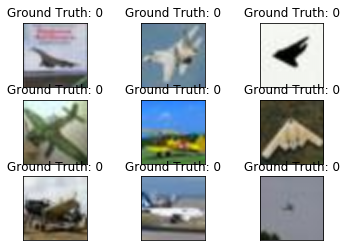

In [6]:
examples = enumerate(testLoader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    #plt.tight_layout()
    plt.imshow(np.transpose(example_data[i], (1, 2, 0)))
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

# ResNet 18 Model

In [7]:
class ResBlock(nn.Module):
    def __init__(self,inChannel,outChannel,isFirstBlock):
        super(ResBlock,self).__init__()
        
        if isFirstBlock:
            strideNum = 1
        else:
            strideNum = 2
        
        self.conv1 = nn.Conv2d(inChannel,outChannel,kernel_size=3,padding=1,stride=strideNum)
        self.bn1 = nn.BatchNorm2d(outChannel)
        self.conv2 = nn.Conv2d(outChannel,outChannel,kernel_size=3,padding=1,stride=1)
        self.bn2 = nn.BatchNorm2d(outChannel)
        
        self.shortcut = nn.Sequential()
        if inChannel != outChannel:
            self.shortcut.add_module('conv',nn.Conv2d(inChannel,outChannel,kernel_size=1,stride=strideNum))
            self.shortcut.add_module('bn',nn.BatchNorm2d(outChannel)) 
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(x)
        
        out = F.relu(out)
        
        return out

    
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()
        
        self.conv1 = nn.Conv2d(3,64,kernel_size=7,padding=3,stride=2)
        self.bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(3,stride=2,padding=1)
        
        self.res1 = self._make_resBlock(64,64,'res1',True)
        self.res2 = self._make_resBlock(64,128,'res2',False)
        self.res3 = self._make_resBlock(128,256,'res3',False)
        self.res4 = self._make_resBlock(256,512,'res4',False)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)
        
    def _make_resBlock(self,inChannel,outChannel,block_name,isFirstBlock):
        resBlock = nn.Sequential()
        resBlock.add_module(block_name, ResBlock(inChannel, outChannel,isFirstBlock))
        
        return resBlock
    
    
    def forward(self,x):
        
        out = self.conv1(x)
        out = F.relu(out)
        out = self.bn(out)
        out = self.pool(out)
        
        out = self.res1(out)        
        out = self.res2(out)        
        out = self.res3(out)        
        out = self.res4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = F.log_softmax(out)
        
        return out

# Create Network

In [8]:
network = ResNet().cuda()
#network.load_state_dict(torch.load("C:\\Users\\jason\\OneDrive\\文件\\Python NN\\Pytorch Pet\\weights161120.pth"))

optimizer = optim.Adam(network.parameters(), weight_decay=0.01,lr=learningRate)
scheduler = ReduceLROnPlateau(optimizer,verbose=True,patience=8,min_lr=1e-6)

print('Memory Usage:')
print('Allocated:', torch.cuda.memory_allocated(0)/1024/1024, 'MB')
print('Cached:   ', torch.cuda.memory_allocated(0)/1024/1024, 'MB')

pytorch_total_params = sum(p.numel() for p in network.parameters())
print("\nTotal Parameters:",pytorch_total_params)

Memory Usage:
Allocated: 18.779296875 MB
Cached:    18.779296875 MB

Total Parameters: 4913802


# Learning Rate Finder

def findLearningRate():
    lr = 1e-7
    
        
    lossArr = []
    dLossArr = []
    d2LossArr = []
    lrArr = []
    
    for idx,(data,label) in enumerate(trainLoader):
        
        
        # Put data to GPU
        data = data.cuda()
        label = label.cuda()
        
        # Computations
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output,label)
        loss.backward()
        optimizer.step()
        
        print(lr,loss.item())
        
        lossArr.append(loss.item())
        lrArr.append(lr)
        lr = lr*1.1
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
        if (lr > 0.1):
            break
    
    return lossArr,lrArr

lossArr,lrArr = findLearningRate()
plt.figure(figsize=(15, 9))
plt.plot(lrArr,lossArr)
plt.ylabel('some numbers')
plt.xscale('log')
plt.show()

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
        
network.apply(weight_reset)

for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-4

# Result Array

In [9]:
trainLossArr = []
trainCounterArr = []
valLossArr = []
valCounterArr = []
testLossArr = []
testCounterArr = [(i+1)*len(trainLoader.dataset) for i in range(epochSize)]

# Training Function

In [9]:
def train(epoch):
    network.train()
    epoch_loss = 0
    epoch_accuracy = 0
    
    currentImg = 0
    totalImg = len(trainLoader.dataset)
    
    for idx,(data,label) in enumerate(trainLoader):
        # Put data to GPU
        data = data.cuda()
        label = label.cuda()
        
        # Computations
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output,label)
        loss.backward()
        optimizer.step()
        
        # Calculate acc and loss
        batch_accuracy = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += (output.argmax(dim=1) == label).float().sum()
        epoch_loss += loss/len(trainLoader)
        
        # Print and record every n interval
        if idx % printInterval == 0:
            
            # Print
            currentImg = idx * len(data)
            epochProgress = currentImg/totalImg
            
            val_accuracy,val_loss = val()
            
            if idx == 0:
                print('Train Epoch: {} [{}/{} (0%)]'.format(epoch,idx, len(trainLoader.dataset)))
            else:                
                print('Train Epoch: {} [{}/{} ({:.0f}%)]  Loss: {:.4f}  Accuracy: {:.4f}  Val_Accuracy: {:.4f}'.format(
                    epoch,currentImg,totalImg,epochProgress*100 ,loss.item(),batch_accuracy,val_accuracy))
            
            # Record
            trainLossArr.append(loss.item())
            trainCounterArr.append(
            (batch_idx*batchSize) + ((epoch-1)*len(trainLoader.dataset)))
            
            valLossArr.append(val_loss)
            valCounterArr.append(
            (batch_idx*batchSize) + ((epoch-1)*len(trainLoader.dataset)))
            
        
    
    # Final print
    print('Train Epoch: {} [{}/{} ({:.0f}%)]  Loss: {:.4f}  Accuracy: {:.4f}  Val_Accuracy: {:.4f}'.format(
                    epoch,totalImg,totalImg,100 ,loss.item(),batch_accuracy,val_accuracy))
    print("Train  Accuracy: {:.4f}  Loss: {:.4f}".format(epoch_accuracy/len(trainLoader.dataset),loss.item()))

# Testing Function

In [10]:
def test():
    network.eval()
    test_loss = 0
    test_accuracy = 0
    idx = 0
    with torch.no_grad():
        for data,label in testLoader:
            # Data to GPU and compute
            data = data.to(device)
            label = label.to(device)
            output = network(data)
            test_loss += F.nll_loss(output,label).item()
            #test_accuracy += ((output.argmax(dim=1) == label).float().mean())/len(testLoader)
            test_accuracy += (output.argmax(dim=1) == label).float().sum()
    
    testLossArr.append(test_loss)
    test_accuracy = test_accuracy/len(testLoader.dataset)
    print("Test  Accuracy: {:.4f}  Loss: {:.4f}".format(test_accuracy,test_loss))
    
    return test_loss,test_accuracy

# Validation Function

In [11]:
def val():
    #network.eval()
    val_loss = 0
    val_accuracy = 0
    idx = 0
    with torch.no_grad():
        for data,label in valLoader:
            data = data.to(device)
            label = label.to(device)
            output = network(data)
            val_loss += F.nll_loss(output,label).item()
            val_accuracy += ((output.argmax(dim=1) == label).float().mean())/len(valLoader)
            
    network.train()
    
    return val_accuracy,val_loss

# Change Weight Decay

In [13]:
def setWeightDecay(acc,wDStage):
    
    acc = acc*100
    if acc> 85 and wDecayStage == 4:
        wDStage = 5
        for param_gp in optimizer.param_groups:
            param_gp['weight_decay'] = 0
            param_gp['lr'] = 2.5e-5
        print('Reduce Weight Decay to ',param_gp['weight_decay'])
    elif acc>80 and wDecayStage == 3:
        wDStage = 4
        for param_gp in optimizer.param_groups:
            param_gp['weight_decay'] = 0.000001
            param_gp['lr'] = 5e-5
        print('Reduce Weight Decay to ',param_gp['weight_decay'])
    elif acc>75 and wDecayStage == 2:
        wDStage = 3
        for param_gp in optimizer.param_groups:
            param_gp['weight_decay'] = 0.00001
            param_gp['lr'] = 1e-4
        print('Reduce Weight Decay to ',param_gp['weight_decay'])
    elif acc>65 and wDecayStage == 1:
        wDStage = 2
        for param_gp in optimizer.param_groups:
            param_gp['weight_decay'] = 0.0001
        print('Reduce Weight Decay to ',param_gp['weight_decay'])
    elif acc>50 and wDecayStage == 0:
        wDStage = 1
        for param_gp in optimizer.param_groups:
            param_gp['weight_decay'] = 0.001
        print('Reduce Weight Decay to ',param_gp['weight_decay'])
    
    return wDStage

# Start training

In [14]:
wDecayStage = 0
maxAcc = 0
for epoch in range(1,epochSize+1):
        
    startEpochTime = time.time()
    train(epoch)
    
    loss,acc = test()
    scheduler.step(loss)
    wDecayStage = setWeightDecay(acc,wDecayStage)
    
    
    if acc > maxAcc:
        maxAcc = acc
        torch.save(network.state_dict(), "C:\\Users\\jason\\OneDrive\\文件\\Python NN\\Pytorch ResNet\\weight211120.pth")
        print("Model Saved")
    
    print("Time: {:.4f}".format(time.time()-startEpochTime),end='\n\n')

c:\users\jason\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]
Train Epoch: 1 [720/50000 (1%)]  Loss: 2.0457  Accuracy: 0.2750  Val_Accuracy: 0.2367
Train Epoch: 1 [1440/50000 (3%)]  Loss: 1.8997  Accuracy: 0.2833  Val_Accuracy: 0.3183
Train Epoch: 1 [2160/50000 (4%)]  Loss: 1.7334  Accuracy: 0.3917  Val_Accuracy: 0.3283
Train Epoch: 1 [2880/50000 (6%)]  Loss: 1.8441  Accuracy: 0.2750  Val_Accuracy: 0.3317
Train Epoch: 1 [3600/50000 (7%)]  Loss: 1.7187  Accuracy: 0.3583  Val_Accuracy: 0.3267
Train Epoch: 1 [4320/50000 (9%)]  Loss: 1.6599  Accuracy: 0.3750  Val_Accuracy: 0.3550
Train Epoch: 1 [5040/50000 (10%)]  Loss: 1.7474  Accuracy: 0.3167  Val_Accuracy: 0.3667
Train Epoch: 1 [5760/50000 (12%)]  Loss: 1.6801  Accuracy: 0.3583  Val_Accuracy: 0.4417
Train Epoch: 1 [6480/50000 (13%)]  Loss: 1.8328  Accuracy: 0.3583  Val_Accuracy: 0.3633
Train Epoch: 1 [7200/50000 (14%)]  Loss: 1.6233  Accuracy: 0.4333  Val_Accuracy: 0.3717
Train Epoch: 1 [7920/50000 (16%)]  Loss: 1.7269  Accuracy: 0.3833  Val_Accuracy: 0.3700
Train Epo

Train Epoch: 2 [15840/50000 (32%)]  Loss: 1.2122  Accuracy: 0.5750  Val_Accuracy: 0.4800
Train Epoch: 2 [16560/50000 (33%)]  Loss: 1.2132  Accuracy: 0.5250  Val_Accuracy: 0.5467
Train Epoch: 2 [17280/50000 (35%)]  Loss: 1.2129  Accuracy: 0.5500  Val_Accuracy: 0.5883
Train Epoch: 2 [18000/50000 (36%)]  Loss: 1.1402  Accuracy: 0.6000  Val_Accuracy: 0.5833
Train Epoch: 2 [18720/50000 (37%)]  Loss: 1.2144  Accuracy: 0.5333  Val_Accuracy: 0.5450
Train Epoch: 2 [19440/50000 (39%)]  Loss: 1.1125  Accuracy: 0.5750  Val_Accuracy: 0.4983
Train Epoch: 2 [20160/50000 (40%)]  Loss: 1.2313  Accuracy: 0.5667  Val_Accuracy: 0.5167
Train Epoch: 2 [20880/50000 (42%)]  Loss: 1.1257  Accuracy: 0.5833  Val_Accuracy: 0.5467
Train Epoch: 2 [21600/50000 (43%)]  Loss: 1.1500  Accuracy: 0.6333  Val_Accuracy: 0.5783
Train Epoch: 2 [22320/50000 (45%)]  Loss: 1.1311  Accuracy: 0.6167  Val_Accuracy: 0.5100
Train Epoch: 2 [23040/50000 (46%)]  Loss: 1.1327  Accuracy: 0.6083  Val_Accuracy: 0.5800
Train Epoch: 2 [23760

Train Epoch: 3 [30960/50000 (62%)]  Loss: 1.0385  Accuracy: 0.6333  Val_Accuracy: 0.5983
Train Epoch: 3 [31680/50000 (63%)]  Loss: 0.9847  Accuracy: 0.6583  Val_Accuracy: 0.6433
Train Epoch: 3 [32400/50000 (65%)]  Loss: 0.9241  Accuracy: 0.7000  Val_Accuracy: 0.6750
Train Epoch: 3 [33120/50000 (66%)]  Loss: 0.9315  Accuracy: 0.6667  Val_Accuracy: 0.6517
Train Epoch: 3 [33840/50000 (68%)]  Loss: 1.1586  Accuracy: 0.5500  Val_Accuracy: 0.5917
Train Epoch: 3 [34560/50000 (69%)]  Loss: 0.9569  Accuracy: 0.6833  Val_Accuracy: 0.6367
Train Epoch: 3 [35280/50000 (71%)]  Loss: 0.9636  Accuracy: 0.6667  Val_Accuracy: 0.6017
Train Epoch: 3 [36000/50000 (72%)]  Loss: 1.0767  Accuracy: 0.6583  Val_Accuracy: 0.5917
Train Epoch: 3 [36720/50000 (73%)]  Loss: 1.0644  Accuracy: 0.6417  Val_Accuracy: 0.5717
Train Epoch: 3 [37440/50000 (75%)]  Loss: 1.2445  Accuracy: 0.5167  Val_Accuracy: 0.6367
Train Epoch: 3 [38160/50000 (76%)]  Loss: 0.9145  Accuracy: 0.6167  Val_Accuracy: 0.5967
Train Epoch: 3 [38880

Train Epoch: 4 [46080/50000 (92%)]  Loss: 0.9620  Accuracy: 0.6333  Val_Accuracy: 0.6750
Train Epoch: 4 [46800/50000 (94%)]  Loss: 0.8447  Accuracy: 0.7167  Val_Accuracy: 0.6433
Train Epoch: 4 [47520/50000 (95%)]  Loss: 0.8553  Accuracy: 0.7000  Val_Accuracy: 0.6633
Train Epoch: 4 [48240/50000 (96%)]  Loss: 0.8636  Accuracy: 0.6833  Val_Accuracy: 0.6617
Train Epoch: 4 [48960/50000 (98%)]  Loss: 0.8422  Accuracy: 0.6833  Val_Accuracy: 0.6483
Train Epoch: 4 [49680/50000 (99%)]  Loss: 0.7830  Accuracy: 0.7250  Val_Accuracy: 0.6100
Train Epoch: 4 [50000/50000 (100%)]  Loss: 0.7765  Accuracy: 0.7625  Val_Accuracy: 0.6100
Train  Accuracy: 0.6605  Loss: 0.7765
Test  Accuracy: 0.6163  Loss: 37.1235
Time: 937.5793

Train Epoch: 5 [0/50000 (0%)]
Train Epoch: 5 [720/50000 (1%)]  Loss: 0.9461  Accuracy: 0.6333  Val_Accuracy: 0.6683
Train Epoch: 5 [1440/50000 (3%)]  Loss: 0.8971  Accuracy: 0.7083  Val_Accuracy: 0.6633
Train Epoch: 5 [2160/50000 (4%)]  Loss: 0.8746  Accuracy: 0.6667  Val_Accuracy: 0

Train Epoch: 6 [10080/50000 (20%)]  Loss: 0.8645  Accuracy: 0.6833  Val_Accuracy: 0.7017
Train Epoch: 6 [10800/50000 (22%)]  Loss: 0.8813  Accuracy: 0.6583  Val_Accuracy: 0.7017
Train Epoch: 6 [11520/50000 (23%)]  Loss: 0.8509  Accuracy: 0.7083  Val_Accuracy: 0.7450
Train Epoch: 6 [12240/50000 (24%)]  Loss: 0.8487  Accuracy: 0.7333  Val_Accuracy: 0.6967
Train Epoch: 6 [12960/50000 (26%)]  Loss: 0.8133  Accuracy: 0.7250  Val_Accuracy: 0.6567
Train Epoch: 6 [13680/50000 (27%)]  Loss: 0.7655  Accuracy: 0.7417  Val_Accuracy: 0.7267
Train Epoch: 6 [14400/50000 (29%)]  Loss: 0.7860  Accuracy: 0.7167  Val_Accuracy: 0.6933
Train Epoch: 6 [15120/50000 (30%)]  Loss: 0.8175  Accuracy: 0.7417  Val_Accuracy: 0.6667
Train Epoch: 6 [15840/50000 (32%)]  Loss: 0.6766  Accuracy: 0.7833  Val_Accuracy: 0.6900
Train Epoch: 6 [16560/50000 (33%)]  Loss: 0.9849  Accuracy: 0.6500  Val_Accuracy: 0.7133
Train Epoch: 6 [17280/50000 (35%)]  Loss: 0.6742  Accuracy: 0.7917  Val_Accuracy: 0.7067
Train Epoch: 6 [18000

Train Epoch: 7 [25200/50000 (50%)]  Loss: 0.8465  Accuracy: 0.7333  Val_Accuracy: 0.7083
Train Epoch: 7 [25920/50000 (52%)]  Loss: 0.8161  Accuracy: 0.7250  Val_Accuracy: 0.6883
Train Epoch: 7 [26640/50000 (53%)]  Loss: 0.7137  Accuracy: 0.7667  Val_Accuracy: 0.7100
Train Epoch: 7 [27360/50000 (55%)]  Loss: 0.8479  Accuracy: 0.6750  Val_Accuracy: 0.7183
Train Epoch: 7 [28080/50000 (56%)]  Loss: 0.6760  Accuracy: 0.7667  Val_Accuracy: 0.6600
Train Epoch: 7 [28800/50000 (58%)]  Loss: 0.7340  Accuracy: 0.7583  Val_Accuracy: 0.7300
Train Epoch: 7 [29520/50000 (59%)]  Loss: 0.6569  Accuracy: 0.7667  Val_Accuracy: 0.7333
Train Epoch: 7 [30240/50000 (60%)]  Loss: 0.6409  Accuracy: 0.7917  Val_Accuracy: 0.7250
Train Epoch: 7 [30960/50000 (62%)]  Loss: 0.8291  Accuracy: 0.7333  Val_Accuracy: 0.7000
Train Epoch: 7 [31680/50000 (63%)]  Loss: 0.8644  Accuracy: 0.6917  Val_Accuracy: 0.7533
Train Epoch: 7 [32400/50000 (65%)]  Loss: 0.6942  Accuracy: 0.7167  Val_Accuracy: 0.7117
Train Epoch: 7 [33120

Train Epoch: 8 [40320/50000 (81%)]  Loss: 0.7257  Accuracy: 0.7667  Val_Accuracy: 0.7400
Train Epoch: 8 [41040/50000 (82%)]  Loss: 0.6752  Accuracy: 0.7333  Val_Accuracy: 0.7450
Train Epoch: 8 [41760/50000 (84%)]  Loss: 0.5304  Accuracy: 0.7917  Val_Accuracy: 0.7750
Train Epoch: 8 [42480/50000 (85%)]  Loss: 0.6112  Accuracy: 0.8250  Val_Accuracy: 0.7600
Train Epoch: 8 [43200/50000 (86%)]  Loss: 0.8566  Accuracy: 0.7250  Val_Accuracy: 0.7067
Train Epoch: 8 [43920/50000 (88%)]  Loss: 0.7785  Accuracy: 0.7417  Val_Accuracy: 0.7317
Train Epoch: 8 [44640/50000 (89%)]  Loss: 0.8165  Accuracy: 0.7083  Val_Accuracy: 0.7317
Train Epoch: 8 [45360/50000 (91%)]  Loss: 0.6794  Accuracy: 0.7750  Val_Accuracy: 0.7450
Train Epoch: 8 [46080/50000 (92%)]  Loss: 0.5569  Accuracy: 0.8083  Val_Accuracy: 0.7667
Train Epoch: 8 [46800/50000 (94%)]  Loss: 0.7250  Accuracy: 0.7000  Val_Accuracy: 0.7150
Train Epoch: 8 [47520/50000 (95%)]  Loss: 0.6874  Accuracy: 0.7417  Val_Accuracy: 0.7733
Train Epoch: 8 [48240

Train Epoch: 10 [4320/50000 (9%)]  Loss: 0.6700  Accuracy: 0.7583  Val_Accuracy: 0.7350
Train Epoch: 10 [5040/50000 (10%)]  Loss: 0.6305  Accuracy: 0.7833  Val_Accuracy: 0.7100
Train Epoch: 10 [5760/50000 (12%)]  Loss: 0.5131  Accuracy: 0.8417  Val_Accuracy: 0.7417
Train Epoch: 10 [6480/50000 (13%)]  Loss: 0.5470  Accuracy: 0.8083  Val_Accuracy: 0.7533
Train Epoch: 10 [7200/50000 (14%)]  Loss: 0.6713  Accuracy: 0.7500  Val_Accuracy: 0.7700
Train Epoch: 10 [7920/50000 (16%)]  Loss: 0.6595  Accuracy: 0.7667  Val_Accuracy: 0.7483
Train Epoch: 10 [8640/50000 (17%)]  Loss: 0.7865  Accuracy: 0.7250  Val_Accuracy: 0.7400
Train Epoch: 10 [9360/50000 (19%)]  Loss: 0.6943  Accuracy: 0.7333  Val_Accuracy: 0.7800
Train Epoch: 10 [10080/50000 (20%)]  Loss: 0.6777  Accuracy: 0.7500  Val_Accuracy: 0.7667
Train Epoch: 10 [10800/50000 (22%)]  Loss: 0.6201  Accuracy: 0.7750  Val_Accuracy: 0.7383
Train Epoch: 10 [11520/50000 (23%)]  Loss: 0.7220  Accuracy: 0.7417  Val_Accuracy: 0.7567
Train Epoch: 10 [12

Train Epoch: 11 [18720/50000 (37%)]  Loss: 0.6885  Accuracy: 0.7917  Val_Accuracy: 0.7117
Train Epoch: 11 [19440/50000 (39%)]  Loss: 0.5166  Accuracy: 0.8083  Val_Accuracy: 0.7617
Train Epoch: 11 [20160/50000 (40%)]  Loss: 0.5019  Accuracy: 0.8083  Val_Accuracy: 0.7800
Train Epoch: 11 [20880/50000 (42%)]  Loss: 0.5119  Accuracy: 0.8500  Val_Accuracy: 0.7217
Train Epoch: 11 [21600/50000 (43%)]  Loss: 0.5489  Accuracy: 0.8333  Val_Accuracy: 0.7567
Train Epoch: 11 [22320/50000 (45%)]  Loss: 0.6826  Accuracy: 0.7250  Val_Accuracy: 0.7183
Train Epoch: 11 [23040/50000 (46%)]  Loss: 0.5597  Accuracy: 0.8167  Val_Accuracy: 0.7800
Train Epoch: 11 [23760/50000 (48%)]  Loss: 0.6596  Accuracy: 0.7917  Val_Accuracy: 0.7517
Train Epoch: 11 [24480/50000 (49%)]  Loss: 0.6010  Accuracy: 0.7750  Val_Accuracy: 0.7283
Train Epoch: 11 [25200/50000 (50%)]  Loss: 0.6258  Accuracy: 0.7917  Val_Accuracy: 0.7350
Train Epoch: 11 [25920/50000 (52%)]  Loss: 0.5910  Accuracy: 0.8167  Val_Accuracy: 0.7867
Train Epoc

Train Epoch: 12 [33120/50000 (66%)]  Loss: 0.6224  Accuracy: 0.8167  Val_Accuracy: 0.7900
Train Epoch: 12 [33840/50000 (68%)]  Loss: 0.6063  Accuracy: 0.7750  Val_Accuracy: 0.7600
Train Epoch: 12 [34560/50000 (69%)]  Loss: 0.5511  Accuracy: 0.7833  Val_Accuracy: 0.7517
Train Epoch: 12 [35280/50000 (71%)]  Loss: 0.5823  Accuracy: 0.8083  Val_Accuracy: 0.7533
Train Epoch: 12 [36000/50000 (72%)]  Loss: 0.5960  Accuracy: 0.8167  Val_Accuracy: 0.7650
Train Epoch: 12 [36720/50000 (73%)]  Loss: 0.6252  Accuracy: 0.7833  Val_Accuracy: 0.7833
Train Epoch: 12 [37440/50000 (75%)]  Loss: 0.6164  Accuracy: 0.7500  Val_Accuracy: 0.7983
Train Epoch: 12 [38160/50000 (76%)]  Loss: 0.6065  Accuracy: 0.7667  Val_Accuracy: 0.7650
Train Epoch: 12 [38880/50000 (78%)]  Loss: 0.3811  Accuracy: 0.8750  Val_Accuracy: 0.7733
Train Epoch: 12 [39600/50000 (79%)]  Loss: 0.5816  Accuracy: 0.7917  Val_Accuracy: 0.8017
Train Epoch: 12 [40320/50000 (81%)]  Loss: 0.5288  Accuracy: 0.8083  Val_Accuracy: 0.7967
Train Epoc

Train Epoch: 13 [47520/50000 (95%)]  Loss: 0.5182  Accuracy: 0.8417  Val_Accuracy: 0.7867
Train Epoch: 13 [48240/50000 (96%)]  Loss: 0.4070  Accuracy: 0.8750  Val_Accuracy: 0.8017
Train Epoch: 13 [48960/50000 (98%)]  Loss: 0.4625  Accuracy: 0.8167  Val_Accuracy: 0.8033
Train Epoch: 13 [49680/50000 (99%)]  Loss: 0.3280  Accuracy: 0.8667  Val_Accuracy: 0.8067
Train Epoch: 13 [50000/50000 (100%)]  Loss: 0.5861  Accuracy: 0.7875  Val_Accuracy: 0.8067
Train  Accuracy: 0.8341  Loss: 0.5861
Test  Accuracy: 0.8371  Loss: 16.1075
Model Saved
Time: 983.4428

Train Epoch: 14 [0/50000 (0%)]
Train Epoch: 14 [720/50000 (1%)]  Loss: 0.4507  Accuracy: 0.8333  Val_Accuracy: 0.7717
Train Epoch: 14 [1440/50000 (3%)]  Loss: 0.2980  Accuracy: 0.9167  Val_Accuracy: 0.7767
Train Epoch: 14 [2160/50000 (4%)]  Loss: 0.4826  Accuracy: 0.8333  Val_Accuracy: 0.8033
Train Epoch: 14 [2880/50000 (6%)]  Loss: 0.3428  Accuracy: 0.8917  Val_Accuracy: 0.8150
Train Epoch: 14 [3600/50000 (7%)]  Loss: 0.5353  Accuracy: 0.81

Train Epoch: 15 [10800/50000 (22%)]  Loss: 0.5876  Accuracy: 0.8333  Val_Accuracy: 0.8083
Train Epoch: 15 [11520/50000 (23%)]  Loss: 0.4969  Accuracy: 0.8250  Val_Accuracy: 0.8250
Train Epoch: 15 [12240/50000 (24%)]  Loss: 0.4479  Accuracy: 0.8333  Val_Accuracy: 0.8233
Train Epoch: 15 [12960/50000 (26%)]  Loss: 0.3513  Accuracy: 0.9083  Val_Accuracy: 0.7967
Train Epoch: 15 [13680/50000 (27%)]  Loss: 0.4154  Accuracy: 0.8583  Val_Accuracy: 0.7917
Train Epoch: 15 [14400/50000 (29%)]  Loss: 0.3396  Accuracy: 0.8917  Val_Accuracy: 0.8150
Train Epoch: 15 [15120/50000 (30%)]  Loss: 0.4779  Accuracy: 0.8250  Val_Accuracy: 0.8217
Train Epoch: 15 [15840/50000 (32%)]  Loss: 0.4938  Accuracy: 0.8167  Val_Accuracy: 0.8100
Train Epoch: 15 [16560/50000 (33%)]  Loss: 0.2880  Accuracy: 0.9083  Val_Accuracy: 0.7717
Train Epoch: 15 [17280/50000 (35%)]  Loss: 0.4333  Accuracy: 0.8333  Val_Accuracy: 0.7950
Train Epoch: 15 [18000/50000 (36%)]  Loss: 0.3901  Accuracy: 0.8750  Val_Accuracy: 0.7750
Train Epoc

Train Epoch: 16 [25200/50000 (50%)]  Loss: 0.3484  Accuracy: 0.8833  Val_Accuracy: 0.8150
Train Epoch: 16 [25920/50000 (52%)]  Loss: 0.3745  Accuracy: 0.8667  Val_Accuracy: 0.8083
Train Epoch: 16 [26640/50000 (53%)]  Loss: 0.4870  Accuracy: 0.8250  Val_Accuracy: 0.8083
Train Epoch: 16 [27360/50000 (55%)]  Loss: 0.4398  Accuracy: 0.8417  Val_Accuracy: 0.8233
Train Epoch: 16 [28080/50000 (56%)]  Loss: 0.4320  Accuracy: 0.8167  Val_Accuracy: 0.8067
Train Epoch: 16 [28800/50000 (58%)]  Loss: 0.3920  Accuracy: 0.8750  Val_Accuracy: 0.8417
Train Epoch: 16 [29520/50000 (59%)]  Loss: 0.3939  Accuracy: 0.8750  Val_Accuracy: 0.8033
Train Epoch: 16 [30240/50000 (60%)]  Loss: 0.4856  Accuracy: 0.8583  Val_Accuracy: 0.8283
Train Epoch: 16 [30960/50000 (62%)]  Loss: 0.3216  Accuracy: 0.8917  Val_Accuracy: 0.7933
Train Epoch: 16 [31680/50000 (63%)]  Loss: 0.3337  Accuracy: 0.8667  Val_Accuracy: 0.8117
Train Epoch: 16 [32400/50000 (65%)]  Loss: 0.4836  Accuracy: 0.7917  Val_Accuracy: 0.8050
Train Epoc

Train Epoch: 17 [39600/50000 (79%)]  Loss: 0.3286  Accuracy: 0.8667  Val_Accuracy: 0.8233
Train Epoch: 17 [40320/50000 (81%)]  Loss: 0.3581  Accuracy: 0.8750  Val_Accuracy: 0.8267
Train Epoch: 17 [41040/50000 (82%)]  Loss: 0.3458  Accuracy: 0.8833  Val_Accuracy: 0.8100
Train Epoch: 17 [41760/50000 (84%)]  Loss: 0.5160  Accuracy: 0.8250  Val_Accuracy: 0.8250
Train Epoch: 17 [42480/50000 (85%)]  Loss: 0.3583  Accuracy: 0.8667  Val_Accuracy: 0.7933
Train Epoch: 17 [43200/50000 (86%)]  Loss: 0.2957  Accuracy: 0.9000  Val_Accuracy: 0.8333
Train Epoch: 17 [43920/50000 (88%)]  Loss: 0.4189  Accuracy: 0.8667  Val_Accuracy: 0.8267
Train Epoch: 17 [44640/50000 (89%)]  Loss: 0.3456  Accuracy: 0.8667  Val_Accuracy: 0.8183
Train Epoch: 17 [45360/50000 (91%)]  Loss: 0.5321  Accuracy: 0.8083  Val_Accuracy: 0.8350
Train Epoch: 17 [46080/50000 (92%)]  Loss: 0.3921  Accuracy: 0.8417  Val_Accuracy: 0.8217
Train Epoch: 17 [46800/50000 (94%)]  Loss: 0.2748  Accuracy: 0.9167  Val_Accuracy: 0.8017
Train Epoc

Train Epoch: 19 [2880/50000 (6%)]  Loss: 0.3623  Accuracy: 0.8833  Val_Accuracy: 0.8283
Train Epoch: 19 [3600/50000 (7%)]  Loss: 0.2555  Accuracy: 0.9000  Val_Accuracy: 0.7867
Train Epoch: 19 [4320/50000 (9%)]  Loss: 0.4179  Accuracy: 0.8167  Val_Accuracy: 0.8083
Train Epoch: 19 [5040/50000 (10%)]  Loss: 0.3624  Accuracy: 0.8833  Val_Accuracy: 0.8183
Train Epoch: 19 [5760/50000 (12%)]  Loss: 0.4336  Accuracy: 0.8500  Val_Accuracy: 0.8067
Train Epoch: 19 [6480/50000 (13%)]  Loss: 0.3804  Accuracy: 0.8417  Val_Accuracy: 0.8450
Train Epoch: 19 [7200/50000 (14%)]  Loss: 0.3013  Accuracy: 0.8917  Val_Accuracy: 0.8200
Train Epoch: 19 [7920/50000 (16%)]  Loss: 0.2955  Accuracy: 0.9083  Val_Accuracy: 0.8233
Train Epoch: 19 [8640/50000 (17%)]  Loss: 0.4404  Accuracy: 0.8167  Val_Accuracy: 0.8417
Train Epoch: 19 [9360/50000 (19%)]  Loss: 0.4920  Accuracy: 0.8333  Val_Accuracy: 0.8017
Train Epoch: 19 [10080/50000 (20%)]  Loss: 0.2961  Accuracy: 0.8917  Val_Accuracy: 0.8483
Train Epoch: 19 [10800/

Train Epoch: 20 [18000/50000 (36%)]  Loss: 0.3999  Accuracy: 0.8667  Val_Accuracy: 0.8133
Train Epoch: 20 [18720/50000 (37%)]  Loss: 0.3782  Accuracy: 0.8750  Val_Accuracy: 0.7900
Train Epoch: 20 [19440/50000 (39%)]  Loss: 0.3874  Accuracy: 0.8750  Val_Accuracy: 0.8233
Train Epoch: 20 [20160/50000 (40%)]  Loss: 0.4417  Accuracy: 0.8750  Val_Accuracy: 0.8267
Train Epoch: 20 [20880/50000 (42%)]  Loss: 0.3648  Accuracy: 0.8500  Val_Accuracy: 0.8200
Train Epoch: 20 [21600/50000 (43%)]  Loss: 0.4885  Accuracy: 0.8083  Val_Accuracy: 0.7933
Train Epoch: 20 [22320/50000 (45%)]  Loss: 0.3696  Accuracy: 0.8500  Val_Accuracy: 0.8100
Train Epoch: 20 [23040/50000 (46%)]  Loss: 0.3882  Accuracy: 0.8750  Val_Accuracy: 0.7717
Train Epoch: 20 [23760/50000 (48%)]  Loss: 0.2411  Accuracy: 0.9250  Val_Accuracy: 0.8283
Train Epoch: 20 [24480/50000 (49%)]  Loss: 0.4037  Accuracy: 0.8417  Val_Accuracy: 0.7883
Train Epoch: 20 [25200/50000 (50%)]  Loss: 0.3660  Accuracy: 0.8833  Val_Accuracy: 0.8333
Train Epoc

Train Epoch: 21 [32400/50000 (65%)]  Loss: 0.3828  Accuracy: 0.8750  Val_Accuracy: 0.8083
Train Epoch: 21 [33120/50000 (66%)]  Loss: 0.3836  Accuracy: 0.8583  Val_Accuracy: 0.8167
Train Epoch: 21 [33840/50000 (68%)]  Loss: 0.4239  Accuracy: 0.8583  Val_Accuracy: 0.8133
Train Epoch: 21 [34560/50000 (69%)]  Loss: 0.3211  Accuracy: 0.8917  Val_Accuracy: 0.8017
Train Epoch: 21 [35280/50000 (71%)]  Loss: 0.5081  Accuracy: 0.8167  Val_Accuracy: 0.8167
Train Epoch: 21 [36000/50000 (72%)]  Loss: 0.3786  Accuracy: 0.8667  Val_Accuracy: 0.7533
Train Epoch: 21 [36720/50000 (73%)]  Loss: 0.3164  Accuracy: 0.8917  Val_Accuracy: 0.8183
Train Epoch: 21 [37440/50000 (75%)]  Loss: 0.4735  Accuracy: 0.8000  Val_Accuracy: 0.7950
Train Epoch: 21 [38160/50000 (76%)]  Loss: 0.2939  Accuracy: 0.9000  Val_Accuracy: 0.8133
Train Epoch: 21 [38880/50000 (78%)]  Loss: 0.4063  Accuracy: 0.8583  Val_Accuracy: 0.8483
Train Epoch: 21 [39600/50000 (79%)]  Loss: 0.4334  Accuracy: 0.8917  Val_Accuracy: 0.8200
Train Epoc

Train Epoch: 22 [46800/50000 (94%)]  Loss: 0.4753  Accuracy: 0.7917  Val_Accuracy: 0.8317
Train Epoch: 22 [47520/50000 (95%)]  Loss: 0.3467  Accuracy: 0.8667  Val_Accuracy: 0.7917
Train Epoch: 22 [48240/50000 (96%)]  Loss: 0.3328  Accuracy: 0.8750  Val_Accuracy: 0.7650
Train Epoch: 22 [48960/50000 (98%)]  Loss: 0.4073  Accuracy: 0.8500  Val_Accuracy: 0.7933
Train Epoch: 22 [49680/50000 (99%)]  Loss: 0.3436  Accuracy: 0.9083  Val_Accuracy: 0.8150
Train Epoch: 22 [50000/50000 (100%)]  Loss: 0.2920  Accuracy: 0.8875  Val_Accuracy: 0.8150
Train  Accuracy: 0.8735  Loss: 0.2920
Test  Accuracy: 0.8508  Loss: 15.1880
Reduce Weight Decay to  0
Model Saved
Time: 1827.1285

Train Epoch: 23 [0/50000 (0%)]
Train Epoch: 23 [720/50000 (1%)]  Loss: 0.3493  Accuracy: 0.8750  Val_Accuracy: 0.8167
Train Epoch: 23 [1440/50000 (3%)]  Loss: 0.4010  Accuracy: 0.8250  Val_Accuracy: 0.8000
Train Epoch: 23 [2160/50000 (4%)]  Loss: 0.3411  Accuracy: 0.8667  Val_Accuracy: 0.8217


KeyboardInterrupt: 

# Plot Training Record

In [ ]:
bufferSize = 10

trainCounterArr = []
for i in range(len(trainLossArr)-bufferSize):
    trainCounterArr.append(i)

trainLossArr_ = []
valLossArr_ = []

for i in range(len(trainLossArr)-bufferSize):
    trainLossArr_.append(np.average(trainLossArr[i:i+bufferSize]))
    valLossArr_.append(np.average(valLossArr[i:i+bufferSize]))

fig = plt.figure()
plt.plot(trainCounterArr, trainLossArr_, color='blue')
plt.plot(trainCounterArr, valLossArr_, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

# Load Saved Weights

In [12]:
network.load_state_dict(torch.load("C:\\Users\\jason\\OneDrive\\文件\\Python NN\\Pytorch ResNet\\weight241120_85.pth"))

<All keys matched successfully>

# Final Test

c:\users\jason\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-5.6507e+00, -5.9994e+00, -1.3047e+01, -9.5606e+00, -7.1014e+00,
         -1.0675e+01, -9.1570e+00, -9.1649e+00, -1.7019e-02, -4.6306e+00],
        [-3.7694e-01, -1.0540e+01, -1.2372e+00, -5.7336e+00, -4.0869e+00,
         -7.8725e+00, -5.9242e+00, -7.5533e+00, -9.2123e+00, -8.9817e+00],
        [-5.5724e+00, -8.1245e+00, -3.2067e+00, -3.2039e+00, -9.5338e-01,
         -1.0751e+00, -4.0778e+00, -1.7686e+00, -1.0223e+01, -7.4739e+00],
        [-1.5167e+01, -2.2209e+01, -8.7021e+00, -7.8356e+00, -1.1490e+01,
         -5.8014e-04, -1.8210e+01, -1.1744e+01, -2.1141e+01, -1.9397e+01],
        [-1.5748e+01, -1.3403e+01, -7.6514e+00, -8.0468e+00, -1.4509e-03,
         -8.2948e+00, -8.9177e+00, -8.2466e+00, -1.4563e+01, -1.1966e+01],
        [-1.7813e+01, -7.2459e+00, -1.9412e+01, -1.6713e+01, -2.0158e+01,
         -1.7924e+01, -1.8590e+01, -1.6289e+01, -1.6732e+01, -7.1357e-04],
        [-1.4113e+01, -1.9194e+01, -1.1692e+01, -3.2114e+00, -1.0439e+01,
         -4.1691e-02, -1.1991e+0

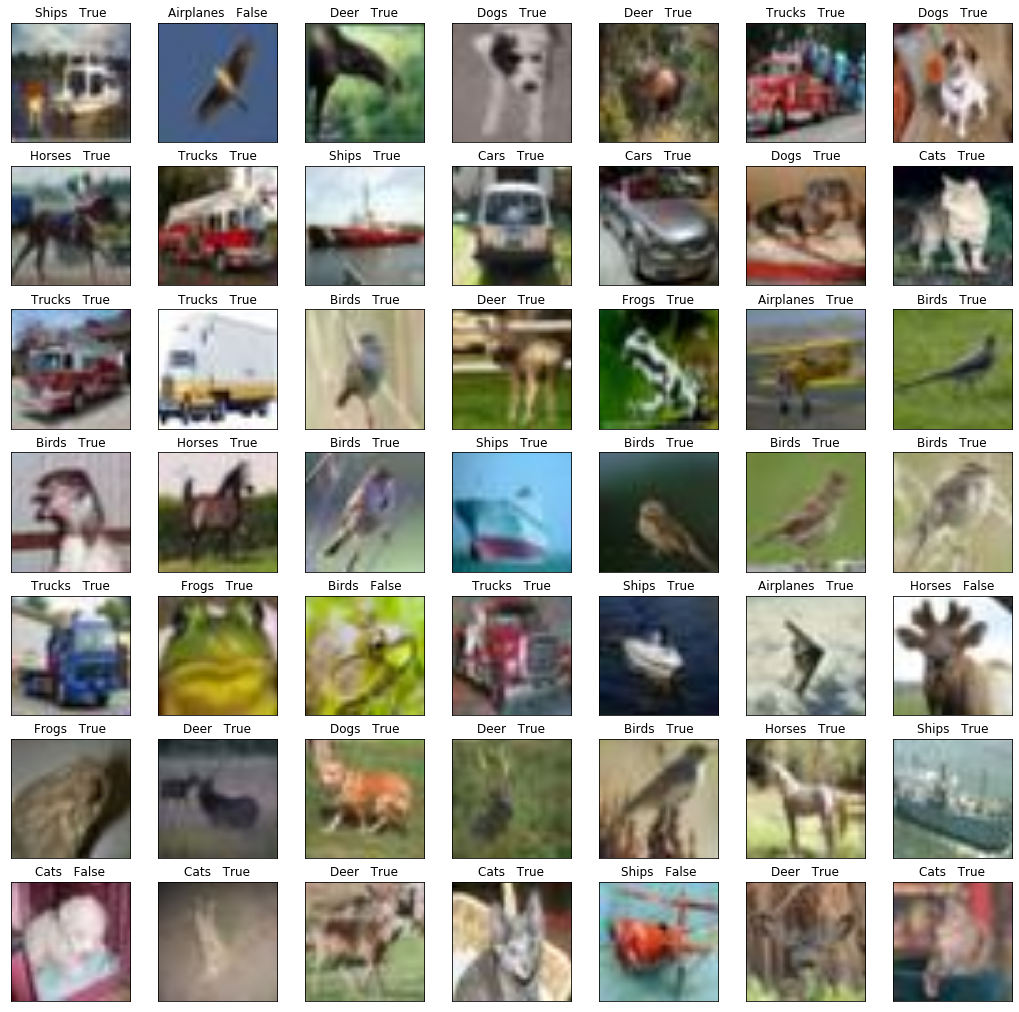

In [13]:
testData = datasets.ImageFolder(testDir,transform = testAugumentation)
testLoader = torch.utils.data.DataLoader(testData,batch_size = 50,shuffle = True)

#loss,acc = test()

examples = enumerate(testLoader)
batch_idx, (example_data, example_targets) = next(examples)
output = network(example_data.cuda())
print(output)
output = output.argmax(dim=1)

fig = plt.figure(figsize=(18, 18))
label = "Airplanes", "Cars", "Birds", "Cats", "Deer", "Dogs", "Frogs", "Horses", "Ships", "Trucks"
for i in range(49):
    plt.subplot(7,7,i+1)
    #plt.tight_layout()
    plt.imshow(np.transpose(example_data[i], (1, 2, 0)))
    title = label[output[i]]+"   "+str((output[i]==example_targets[i]).item())
    plt.title(title)#"Ground Truth: {}".format(example_targets[i])
    plt.xticks([])
    plt.yticks([])

# Load Result

In [ ]:
testDataSize = 10000
testSize = 50

output_epoch = np.zeros([testDataSize,outSize])
ans = np.zeros([testDataSize])
out = np.zeros([testDataSize,2])

for i, (x, y) in enumerate(testLoader):
    x = x.cuda()
    output_epoch[i*testSize:(i+1)*testSize,:] = network(x).cpu().detach().numpy()
    ans[i*testSize:(i+1)*testSize] = y.cpu()
    
    output_batch = F.softmax(network(x), dim=1)
    for j in range(np.shape(output_batch)[0]):
        out[i*testSize+j,0] = output_batch[j].argmax()
        out[i*testSize+j,1] = output_batch[j].max().detach().cpu().numpy()

print(out)
# out: [label,prop]

# Find Best 5 and Worst 5

In [ ]:
class_max = np.zeros([outSize,10])
# class_max: [1st pos_dataset,...,5th pos_dataset , 1st val,...,5th val]

for i in range(testDataSize):
    idx = out[i,0]
    val = out[i,1]
    if val > class_max[int(idx),5]:
        class_max[int(idx),6:9] = class_max[int(idx),5:8]
        class_max[int(idx),5] = val
        class_max[int(idx),1:4] = class_max[int(idx),0:3]
        class_max[int(idx),0] = i
    elif val > class_max[int(idx),6]:
        class_max[int(idx),7:9] = class_max[int(idx),6:8]
        class_max[int(idx),6] = val
        class_max[int(idx),2:4] = class_max[int(idx),1:3]
        class_max[int(idx),1] = i
    elif val > class_max[int(idx),7]:
        class_max[int(idx),8:9] = class_max[int(idx),7:8]
        class_max[int(idx),7] = val
        class_max[int(idx),3:4] = class_max[int(idx),2:3]
        class_max[int(idx),2] = i
    elif val > class_max[int(idx),8]:
        class_max[int(idx),9] = class_max[int(idx),8]
        class_max[int(idx),8] = val
        class_max[int(idx),4] = class_max[int(idx),3]
        class_max[int(idx),3] = i
    elif val > class_max[int(idx),9]:
        class_max[int(idx),9] = val
        class_max[int(idx),4] = i
        
class_min = np.zeros([outSize,10])+1000

for i in range(testDataSize):
    idx = out[i,0]
    val = out[i,1]
    if val < class_min[int(idx),5]:
        class_min[int(idx),6:9] = class_min[int(idx),5:8]
        class_min[int(idx),5] = val
        class_min[int(idx),1:4] = class_min[int(idx),0:3]
        class_min[int(idx),0] = i
    elif val < class_min[int(idx),6]:
        class_min[int(idx),7:9] = class_min[int(idx),6:8]
        class_min[int(idx),6] = val
        class_min[int(idx),2:4] = class_min[int(idx),1:3]
        class_min[int(idx),1] = i
    elif val < class_min[int(idx),7]:
        class_min[int(idx),8:9] = class_min[int(idx),7:8]
        class_min[int(idx),7] = val
        class_min[int(idx),3:4] = class_min[int(idx),2:3]
        class_min[int(idx),2] = i
    elif val < class_min[int(idx),8]:
        class_min[int(idx),9] = class_min[int(idx),8]
        class_min[int(idx),8] = val
        class_min[int(idx),4] = class_min[int(idx),3]
        class_min[int(idx),3] = i
    elif val < class_min[int(idx),9]:
        class_min[int(idx),9] = val
        class_min[int(idx),4] = i

In [ ]:
print('MAX')
for i in range(outSize):
    for j in range(5):
        img = testData.__getitem__(int(class_max[i,j]))[0]
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(1,5,j+1)
        plt.imshow(img)
        plt.title("Idx:{}".format(int(class_max[i,j])+11500))
    plt.show()

print('MIN')
for i in range(outSize):
    for j in range(5):
        img = testData.__getitem__(int(class_min[i,j]))[0]
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(1,5,j+1)
        plt.imshow(img)
        plt.title("Idx:{}".format(int(class_min[i,j])+11500))
    plt.show()

In [ ]:
ConfusionMatrix = np.zeros([outSize,outSize])

for i in range(testDataSize):
    ConfusionMatrix[int(ans[i]),int(out[i,0])] = ConfusionMatrix[int(ans[i]),int(out[i,0])]+1
    
print(ConfusionMatrix)

positive = np.zeros([outSize])
negative = np.zeros([outSize])

for i in range(outSize):
    positive[i] = ConfusionMatrix[i,i]/np.sum(ConfusionMatrix[:,i])
    negative[i] = (np.sum(ConfusionMatrix[:i,:i])+np.sum(ConfusionMatrix[(i+1):,:i])+np.sum(ConfusionMatrix[:i,(i+1):])+np.sum(ConfusionMatrix[(i+1):,(i+1):]))/(np.sum(ConfusionMatrix[:,:i])+np.sum(ConfusionMatrix[:,(i+1):]))

print("\n Airplane   Automobile Bird       Cat        Deer       Dog\n Frog       Horse      Ship       Truck")
print(positive)
print(negative)

In [ ]:
print('Memory Usage:')
print('Allocated:', torch.cuda.memory_allocated(0)/1024/1204, 'MB')
print('Cached:   ', torch.cuda.memory_allocated(0)/1024/1024, 'MB')